In [48]:
import os
import random
import numpy as np
import pandas as pd

import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set up working directory - adjust this to where the repo is stored locally
%cd '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis'

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis


# ABOUT
__Author:__ Pat McCornack

__Data Created:__ 09/27/24

__Description:__ Define conditions under which fog occurs using summary statistics from a curated collection of fog data from the Pozo ridge met. station in August 2022. These conditions are then applied to the following datasets to determine the frequency at which fog does or does occur under these conditions. Plots visualizing these frequencies are plotted for comparison.

Datasets:
1. The full Pozo ridge fog dataset
2. Chris Still's SAUC data
3. Other Still data? 

__Notes:__ 
- Data curated to create very strong fog signal. Light fog events and isolated tips were removed, and the tails of fog events were removed (due to accumulated condensate continuing to drip after the fog event has passed). However, this does not address the problem of nonproductive fog events.

# Functions
----

In [49]:
# Check dew point
def calc_dew_point(temp_series, rh_series):
    """
    Return a list of dew points calculated from temperature and relative humidity.

    The dew point is the temperature at which air becomes saturated with moisture and 
    water vapor starts to condense.
    
    Parameters
    ----------
    temp_series : pandas.Series
        A Pandas Series of air temperatures in degrees Celsius.
    rh_series : pandas.Series 
        A Pandas Series of relative humidity values as percentages.

    Return
    ------
    list
        A list of dew point values in degrees Celsius, corresponding to the input temperatures and humidity.
    """
    b = 17.625
    c = 243.04

    dew_point = []
    for i in range(len(temp_series)):
        gamma = np.log((rh_series.iloc[i]/100)) + (b*temp_series.iloc[i])/(c+temp_series.iloc[i])
        dp = (c * gamma) / (b - gamma)

        dew_point.append(dp)

    return dew_point

# Calculate dew point depression
def calc_dpd(airtemp_series, dewpoint_series):
    """ 
    Calculate the dew point depression (DPD), which is the difference between the air 
    temperature and the dew point temperature. Dew point depression is a measure of 
    how much the air needs to cool for saturation to occur.

    Parameters
    ----------
    airtemp_series : pandas.Series
        A Pandas Series of air temperatures in degrees Celsius.
    dewpoint_series : pandas.Series
        A Pandas Series of dew point temperatures in degrees Celsius.

    Returns
    -------
    pandas.Series
        A Pandas Series containing the dew point depression values in degrees Celsius.

    """
    # Calculate dew point depression
    dpd = airtemp_series - dewpoint_series

    return dpd 

# Filter dataframe for observations based on 'fog conditions'
def fog_rule_filter(data_df, stats_df, var_list, inverse=False, stat_bounds=('min', 'max')):
    """
    Filters the input dataframe to only observations which match conditions defined using stats_df, or if 
    inverse is set to true, then finds observations which do not match the conditions. This is used to assess
    rules defining conditions under which fog may occur. 

    Parameters
    ----------
    data_df : pandas.DataFrame
        The dataframe of met station data to be filtered.
    stats_df : pandas.DataFrame
        Summary statistics returned using pandas DataFrame.describe() used to define fog conditions.
    var_list : list
        A list describing what features to use to define fog conditions. 
    inverse : bool
        If set to True, then returns only observations that do not match the conditions.
    stat_bounds : tuple
        Defines what to use to set bounds of fog rules based on stats_df.

    Returns
    -------
    pandas.DataFrame
        A Pandas DataFrame that was filtered based on the conditions defined using stats_df.
    """
    df = data_df.copy()
    match_df = data_df.copy()

    # Get dataframe of observations matching conditions
    for var in var_list:
        match_df = match_df.loc[df[var].between(stats_df[var][stat_bounds[0]], stats_df[var][stat_bounds[1]])]

    # If inverse=True then return observations that don't match the conditions
    if inverse:
        match_indices = match_df.index.tolist()
        nonmatch_df = df.drop(match_indices)
        return nonmatch_df
    else:
        return match_df

# Remove outliers with IQR method
def remove_outliers(df, feature_list):
    """
    Remove outliers from the specified features in the dataframe using the Interquartile 
    Range (IQR) method. The IQR method defines outliers as data points that fall outside 
    of 1.5 times the IQR below the first quartile (Q1) or above the third quartile (Q3).

    Parameters
    ----------
    df : pandas.DataFrame
        The input Pandas DataFrame containing the data.
    feature_list : list
        A list of column names (features) from the DataFrame for which outliers should be removed.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with outliers removed from the specified features.
    """
    for feature in feature_list:
        # Define quantiles
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)

        # Calculate inter-quartile range
        IQR = Q3 - Q1

        # Define thresholds based on IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove points outside of threshold
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

    return df

# Get stats
def get_match_stats(site_df, fog_conditions, feature_list, site_name):
    """
    Calculate and return statistics describing the frequency with which observations from a met station
    at the given site match rules set using fog_conditions meant to capture under what atmospheric conditions 
    fog forms. 

    Parameters
    ----------
    site_df : pandas.DataFrame
        The input dataframe containing observations for a specific site.
    fog_conditions (pd.DataFrame): A DataFrame of summary statistics used to define the filter ruleset. 
                           This is used to filter the data and identify matches.
    feature_list : list
        A list of column names (features) to apply the conditions on.
    site_name : str
        The name of the site being analyzed.

    Returns
    -------
    list
        A list of statistics to be appended to a dataframe gathering results of multiple sites.
    """
    site = site_name
    total_count = site_df.shape[0]
    date_range = site_df['time'].describe()
    start_date  = str(date_range['min']).split(' ')[0]
    end_date = str(date_range['max']).split(' ')[0]

    # Get matching stats
    inside_df = fog_rule_filter(site_df, fog_conditions, feature_list, stat_bounds=('min', 'max'))
    inside_count = inside_df.shape[0]
    inside_perc = inside_count / total_count
    
    inside_fog_counts = inside_df['condition'].value_counts(normalize=False)
    inside_fog = inside_fog_counts['fog'] / total_count
    inside_no_fog = inside_fog_counts['no fog'] / total_count

    # Get nonmatching stats
    outside_df = fog_rule_filter(site_df, fog_conditions, feature_list, inverse=True, stat_bounds=('min', 'max'))
    outside_count = outside_df.shape[0]
    outside_perc = outside_count / total_count
    
    outside_fog_counts = outside_df['condition'].value_counts(normalize=False)
    outside_fog = outside_fog_counts['fog'] / total_count
    outside_no_fog = outside_fog_counts['no fog'] / total_count

    return [site, total_count, inside_count, inside_perc, inside_fog, inside_no_fog, outside_count,
                                   outside_perc, outside_fog, outside_no_fog, start_date, end_date]

def subset_cols(df, var_name_dict, key):
    """
    Subsets and renames columns based on provided dictionary for a given dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe of meteorological data.
    var_name_dict : dict
        Dictionary containing mappings between original and new variable names.
    key : str
        Key corresponding to which dataset to apply this to.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with subset and renamed columns. 

    """
    df = df[list(var_name_dict[key].values())]  # subset
    df.columns = list(var_name_dict[key].keys())  # rename
    

    return df

def plot_results(results_df, figsize=(15,2), out_fpath=None):
    """
    Creates horizontal bar charts breaking down how many observations met the defined 'fog conditions'
    and how many of each category were labeled fog or not fog.

    Parameters
    ----------
    results_df : pandas.DataFrame
        Dataframe returned from get_match_stats(), subset to a single site. Contains statistics of which observations met 'fog conditions'
    figsize : tuple
        Size of the plotted figure. 
    out_fpath : str
        File path to which save the figure (if applicable).

    Returns
    -------
    None
    """

    fig, ax = plt.subplots(figsize=figsize)
    # Define values
    inside = results_df['inside_perc']
    outside = 1 - inside

    inside_fog = results_df['inside_fog']
    inside_no_fog = results_df['inside_no_fog']
    outside_fog = results_df['outside_fog']
    outside_no_fog = results_df['outside_no_fog']

    # Define Bar Positions
    width = 0.25
    offset = width + width/2

    # Define inside/outside ratio bars
    top1 = ax.barh(offset, inside, width,
                edgecolor='black', color='cornflowerblue', label='Inside Aug. Range')
    
    top2 = ax.barh(offset, outside, width, left=inside,
                edgecolor='black', color='orangered', label='Outside Aug. Range')

    # Define drip/no drip ratio bars
    bot1 = ax.barh(width/2, inside_fog, width,
                edgecolor='black', color='lightblue', label='Fog Drip Occurred')
    
    bot2 = ax.barh(width/2, inside_no_fog, width, left=inside_fog,
                edgecolor='black', color='orange', label='Fog Drip Did Not Occur')
    
    bot3 = ax.barh(width/2, outside_fog, width, left=inside_fog + inside_no_fog,
                edgecolor='black', color='lightblue')
    
    bot4 = ax.barh(width/2, outside_no_fog, width,
                left=(inside_fog + inside_no_fog + outside_fog), 
                edgecolor='black', color='orange')

    # Label bars
    for bar in [top1, top2]:
        ax.bar_label(bar, fmt=lambda x: f'{x * 100:.1f}%', label_type='center')

    for bar in [bot1, bot2, bot3, bot4]:
        ax.bar_label(bar, fmt=lambda x: f'{x * 100:.1f}%', label_type='center')

    # Define plot display parameters
    ax.grid(False)
    plt.axis('off')
    plt.legend(loc='right')
    plt.title(f'{results_df['site']}\nTotal Count: {results_df['total_count']}\n{results_df['start_date']} - {results_df['end_date']}')

    if out_fpath != None:
        plt.savefig(out_fpath)
        
    plt.show()

def results_bar_plot(results_df, figsize=(12, 6)):
    """
    Displays the results as an intersite comparison, with subplots corresponding to the statistic and
    bars corresponding to sites. 
    
    Parameters
    ----------
    results_df : pandas.DataFrame
         Dataframe returned from get_match_stats(). Contains statistics of which observations met 'fog conditions'
    figsize : tuple
        Size of plot.          

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(2,2, figsize=figsize)

    # Inside August Range
    sns.barplot(data=results_df,
                x='site',
                y='inside_fog',
                color='lightblue',
                edgecolor='black',
                ax=ax[0][0])
    ax[0][0].set(title='Inside August Range\nFog Drip Occurred', xlabel='', ylabel='Ratio')

    sns.barplot(data=results_df,
                x='site',
                y='inside_no_fog',
                color='orange',
                edgecolor='black',
                ax=ax[0][1])
    ax[0][1].set(title='Inside August Range\nNo Fog Drip Occurred', xlabel='', ylabel='Ratio')

    # Outside August Range
    sns.barplot(data=results_df,
                x='site',
                y='outside_fog',
                color='lightblue',
                edgecolor='black',
                ax=ax[1][0])
    ax[1][0].set(title='Outside August Range\nFog Drip Occurred', xlabel='', ylabel='Ratio')

    sns.barplot(data=results_df,
                x='site',
                y='outside_no_fog',
                color='orange',
                edgecolor='black',
                ax=ax[1][1])
    ax[1][1].set(title='Outside August Range\nNo Fog Drip Occurred', xlabel='', ylabel='Ratio')

    plt.tight_layout()
    plt.show()

# Called by find_events - adds a time buffer around rain/fog events
def buffer_events(event_list, buffer_size=4):
    """
    Called by find_fog_events. Add a buffer of buffer_size hours to either side of the identified fog event.

    Parameters
    ----------
    event_list : list of lists
        Lists of lists of the form [start_time, stop_time] of identified fog events.
    buffer_size : int
        Size of buffer to apply in hours

    Returns
    -------
    Event list updated by adding a buffer of buffer_size hours to either side.
    """
    updated_event_list = []
    for pair in event_list:
        start_time = dt.datetime.strptime(str(pair[0]), '%Y-%m-%d %H:%M:%S')
        start_time = start_time - timedelta(hours=buffer_size)
        stop_time = dt.datetime.strptime(str(pair[1]), '%Y-%m-%d %H:%M:%S')
        stop_time = stop_time + timedelta(hours=buffer_size)

        updated_event_list.append([start_time, stop_time])
    
    return updated_event_list

# Finds fog events over a certain duration
def find_fog_events(df, event_duration = 3, buffer_size=4):
    """
    Finds fog events of event_duration size (in hours). That is, finds sets of observations where fog != 0 for event_duration 
    consecutive hours. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with meteorological observations.
    event_duration : int
        Duration of fog event in hours to find.
    buffer_size : int
        Size of buffer in hours to apply to either side of extracted fog events.

    Returns
    -------
    list of lists
        list of lists of fog event timestamps in the form [start_time, stop_time].
    """
    event = 0
    row_count = 0
    events = []
    time_steps = event_duration * 6
    for i, row in df.iterrows():
        # At the start of fog event
        if (row['transition'] == True) & (row['condition'] == 'fog'):
            row_count = 1  # Initialize row count
            start_time = row['time']
            event = 1

        if event == 1:
            row_count += 1

        if (row['transition'] == True) & (row['condition'] != 'fog'):
            event = 0
            if row_count >= time_steps:
                stop_time = row['time']
                events.append([start_time, stop_time])

            
    events = buffer_events(events, buffer_size = buffer_size)
    return events

def week_plot(fog_event, xtick_interval=6, out_fpath=None):
    """
    Plots results as a timeseries for a given week, supplied by find_fog_events. 

    Parameters
    ----------
    fog_event : pandas.DataFrame
        Dataframe spanning a single fog event.
    xtick_interval : int
        Interval over which to place xticks (xtick_interval=6 mean one tick every hour)
    out_fpath : str
        Filepath to which to save the plot (if applicable)
    
    Returns
    -------
    None
    """
    fog_event = fog_event.copy()
    fog_event['x_time'] = fog_event['time'].apply(lambda x: x.time())

    start_date = fog_event['time'].iloc[0]
    stop_date = fog_event['time'].iloc[-1]

    start_time = fog_event['x_time'].iloc[0]
    stop_time = fog_event['x_time'].iloc[-1]
    xticks = fog_event.index[::xtick_interval].tolist()
    
    fig, ax = plt.subplots(figsize=(15, 6))

    # Increase the font size of x and y axis tick labels
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Fog Harp Drip in mL/10 minutes', fontsize=16)

    category_palette = {
        'inside_fog': 'lightblue',
        'inside_no_fog': 'orange',
        'outside_fog': 'blue',
        'outside_no_fog': 'red'
    }

    # Plot Fog as bar plot
    sns.barplot(data=fog_event,
                x='x_time',
                y='fog',
                hue='fog_label',  # Use 'fog_label' for hue
                palette=category_palette,
                alpha=0.5,
                ax=ax)

    plt.xticks(ticks=xticks, labels=fog_event.iloc[xticks]['x_time'], rotation=90)

    ax2 = ax.twinx()
    
    # Scatter plot for Fog
    sns.scatterplot(data=fog_event,
                    x=fog_event.index,
                    y='fog',
                    hue='fog_label',  # Use 'fog_label' for hue
                    palette=category_palette,
                    alpha=1,
                    ax=ax2)
    
    ax2.set_ylim(bottom=0)
    ax2.get_yaxis().set_visible(False)
    ax2.grid(False)

    ax3 = ax.twinx()
    ax3.set_ylabel('Relative Humidity', fontsize=16)
    
    # Line plot for RH
    sns.lineplot(data=fog_event,
                 x=fog_event.index,
                 y='RH',
                 color='gray',
                 alpha=0.5,
                 label='RH',  # Assign a label for RH
                 ax=ax3)
    
    ax3.set_ylim(75, 105)

    # Hide the legends of the individual plots
    ax.legend_.remove()  # Remove the legend from the bar plot
    ax2.legend_.remove()  # Remove the legend from the scatter plot
    ax3.legend_.remove()  # Remove the legend from the line plot

    # Collect handles and labels for the combined legend
    handles, labels = ax.get_legend_handles_labels()
    
    # Add RH to the handles and labels
    handles.append(ax3.get_lines()[0])  # Get the line from ax3
    labels.append('RH')  # Add label for RH
    
    # Create a single legend
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)

    ax.grid(False)

    plt.title(f'{start_date.date()}', fontsize=20)
    plt.show()

# Main
----

## Get August Conditions

In [50]:
# Used to get list of all columns
df_fpath = './data/03-processed/smo2-curatedfog-aug22.csv'
df = pd.read_csv(df_fpath)
#df.columns

In [51]:
#### Load and Pre-process Data #####

# Read in data
df_fpath = './data/03-processed/smo2-curatedfog-aug22.csv'
df = pd.read_csv(df_fpath)

# Subset to select variables 
col_subset = ['time', 'fog-harp-ml', 'fog-remove-flag', 'relative-humidity-minimum-rh-min-pct',
       'air-temperature-minimum-degc', 'barometric-pressure-average-bp-mbar-avg-mb',
       'leaf-wetness-average-l-wm-v-avg-mv',
       'rainfall-sum-rain-mm-tot-mm',
       'barometric-pressure-average-vp-mbar-avg-mb',
       'wind-speed-wind-vector-cells-ws-ms-u-wvt-ms',
        'air-temperature-wind-vector-cells-wind-dir-sdu-wvt-deg']

col_names = ['time', 'fog', 'fog_flag', 'RH', 'air_temp', 'atm_pressure',
             'leaf_wetness', 'rainfall', 'vapor_pressure', 'wind_speed_avg',
              'wind_dir']
df = df[col_subset]
df.columns = col_names

# Create variables
df['dew_point'] = calc_dew_point(df['air_temp'], df['RH'])
df['dew_point_depression'] = calc_dpd(df['air_temp'], df['dew_point'])

# Remove flagged fog observations to create strong fog signal
df = df.loc[df['fog_flag'] != True]
df.drop('fog_flag', axis=1, inplace=True)

# Label fog observations
df['condition'] = df['fog'].apply(lambda x: 'fog' if x != 0 else 'no fog')

In [52]:
#### Get fog condition summary statistics ####
# Filter to fog observations
df_fog = df.loc[df['condition'] == 'fog']

# Remove outliers
feature_list = ['RH', 'air_temp', 'atm_pressure', 'leaf_wetness', 'rainfall', 'vapor_pressure', 'wind_speed_avg',
              'wind_dir']
#df_fog = remove_outliers(df_fog, feature_list)

# Remove the biggest outlier
df_fog = df_fog.loc[df_fog['RH'] != 92.5]

# Get summary stats - i.e. fog conditions
fog_conditions = df_fog.describe()
print(f'Shape with all fog points:\n{df_fog.shape}')
print(f'Shape after removing outliers:\n{df_fog.shape}')
fog_conditions

Shape with all fog points:
(1073, 13)
Shape after removing outliers:
(1073, 13)


,fog,RH,air_temp,atm_pressure,leaf_wetness,rainfall,vapor_pressure,wind_speed_avg,wind_dir,dew_point,dew_point_depression
count,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00
mean,16.68,99.67,13.28,985.41,311.86,0.00,15.34,2.72,16.12,13.23,0.05
std,12.76,0.59,0.80,2.12,31.85,0.00,0.80,1.57,8.24,0.80,0.09
min,3.78,96.30,11.40,980.21,172.60,0.00,13.71,0.10,7.45,11.40,-0.00
25%,7.56,99.50,12.80,983.70,292.50,0.00,14.85,1.38,12.85,12.78,-0.00
50%,15.12,100.00,13.20,985.10,319.50,0.00,15.28,2.37,14.41,13.18,0.00
75%,22.68,100.00,13.70,987.01,334.40,0.00,15.84,3.93,16.23,13.68,0.08
max,79.38,100.00,15.80,989.88,389.80,0.02,18.02,9.18,70.41,15.80,0.58


## Apply Conditions to Full Datasets
For each dataset, assess how well the August 2022 fog conditions capture fog events. 

Note that SAUC did not have atmospheric pressure and that there were multiple options for most of the variables. VPD needed to be rejoined back in. Leaf wetness values are too different to use.
Too many missing wind observations.

For first pass: Removed atm_pressure, vpd/vapor_pressure, leaf wetness, wind speed

### Define file paths and variable names/aliases

In [53]:
#### Define dataset-specific variable names and fpaths ####
fpath_dict = {
    'pozo' : './data/01-raw/met-station/sci-pozo-smo2-2021-2023.csv',
    'sauc' : './data/01-raw/met-station/still-lab/sci-sauc-2003-2008.csv',
    'upem' : './data/01-raw/met-station/still-lab/sci-upem-july-sept-2010.csv',
    'crak' : './data/01-raw/met-station/still-lab/tblCrak.csv',
    'crat' : './data/01-raw/met-station/still-lab/tblCRat.csv',
    'erdg' : './data/01-raw/met-station/still-lab/tblERdg.csv',
    'wrdg' : './data/01-raw/met-station/still-lab/tblWRdg.csv'
}

var_name_dict = {
    'pozo' : {
        'time' : 'time',
        'fog' : 'fog-harp-ml',
        'RH' : 'relative-humidity-minimum-rh-min-pct',
        'air_temp' : 'air-temperature-minimum-degc',
        'rainfall' : 'rainfall-sum-rain-mm-tot-mm',
        'atm_pressure' : 'barometric-pressure-average-bp-mbar-avg-mb',
        'vapor_pressure' : 'barometric-pressure-average-vp-mbar-avg-mb',
        'wind_speed_avg' : 'wind-speed-wind-vector-cells-ws-ms-u-wvt-ms',
        'leaf_wetness' : 'leaf-wetness-average-l-wm-v-avg-mv'
    },

    'sauc' : {
        'time' : 'time',
        'fog' : 'Fog',
        'RH' : 'RH',
        'air_temp' : 'Temp',
        'rainfall' : 'Rain',
        'wind_speed_avg' : 'WindSpd',
        'leaf_wetness' : 'LeafWet'
    },

    'upem' : {
        'time' : 'time',
        'fog' : 'fog_mm_tot',
        'RH' : 'rh_min',
        'air_temp' : 'airtc_min',
        'rainfall' : 'rain_converted_mm',
        'wind_speed_avg' : 'ws_ms_avg'
    },

    'still_data' : {
        'time' : 'Date',
        'fog' : 'Fog',
        'RH' : 'RH',
        'air_temp' : 'Temp',
        'rainfall' : 'Rain',
        'wind_speed_avg' : 'WindSpd',
        'leaf_wetness' : 'LeafWet'
    }
}

### Dataset Specific Preprocessing

In [54]:
#### Read/Process Data #####
# Read in data
pozo_df = pd.read_csv(fpath_dict['pozo'])
sauc_df = pd.read_csv(fpath_dict['sauc'])
upem_df = pd.read_csv(fpath_dict['upem'])
crat_df = pd.read_csv(fpath_dict['crat'])
crak_df = pd.read_csv(fpath_dict['crak'])
erdg_df = pd.read_csv(fpath_dict['erdg'])
wrdg_df = pd.read_csv(fpath_dict['wrdg'])

# Create timestamp for sauc
sauc_df['time'] = pd.to_datetime(sauc_df[['Year', 'Month' ,'Day', 'Hour', 'Minute']])
upem_df['time'] = pd.to_datetime(upem_df[['year', 'month' ,'day', 'hour', 'minute']])

# Subset/rename columns + cast to datetime
sauc_df = subset_cols(sauc_df, var_name_dict, 'sauc')
pozo_df = subset_cols(pozo_df, var_name_dict, 'pozo')
upem_df = subset_cols(upem_df, var_name_dict, 'upem')
crat_df = subset_cols(crat_df, var_name_dict, 'still_data')
crak_df = subset_cols(crak_df, var_name_dict, 'still_data')
erdg_df = subset_cols(erdg_df, var_name_dict, 'still_data')
wrdg_df = subset_cols(wrdg_df, var_name_dict, 'still_data')

name_list = ['Sauc', 'Upem', 'Pozo', 'Crat', 'Crak', 'Erdg', 'Wrdg']
df_list = [sauc_df, upem_df, pozo_df, crat_df, crak_df, erdg_df, wrdg_df]
for df in df_list[2:]:
    df['time'] = pd.to_datetime(df['time'])

/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/4168702260.py:8: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  erdg_df = pd.read_csv(fpath_dict['erdg'])
/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/4168702260.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])
/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/4168702260.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])
/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/4168702260.py:27: UserWarning: Could not infer format, so each element will be parsed individu

### General Preprocessing

In [55]:
#### Create Features for Each DataFrame ####
for df in df_list:
    # Break timestamp into separate variables
    df['month'] = [datetime.month for datetime in df['time']]
    df['day'] = [datetime.day for datetime in df['time']]
    df['clock_time'] = [str(datetime.time()) for datetime in df['time']]

    # Label fog observations
    df['condition'] = df['fog'].apply(lambda x: 'fog' if x != 0 else 'no fog')

    # Create dew point and dpd
    df['dew_point'] = calc_dew_point(df['air_temp'], df['RH'])
    df['dew_point_depression'] = calc_dpd(df['air_temp'], df['dew_point'])

/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/639320544.py:26: RuntimeWarning: divide by zero encountered in log
  gamma = np.log((rh_series.iloc[i]/100)) + (b*temp_series.iloc[i])/(c+temp_series.iloc[i])
/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/639320544.py:27: RuntimeWarning: invalid value encountered in scalar divide
  dp = (c * gamma) / (b - gamma)
/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/639320544.py:26: RuntimeWarning: invalid value encountered in log
  gamma = np.log((rh_series.iloc[i]/100)) + (b*temp_series.iloc[i])/(c+temp_series.iloc[i])
/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/639320544.py:26: RuntimeWarning: invalid value encountered in log
  gamma = np.log((rh_series.iloc[i]/100)) + (b*temp_series.iloc[i])/(c+temp_series.iloc[i])
/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_8654/639320544.py:26: RuntimeWarning: divide by zero encountered in log
  gamma = np.log((rh_series.i

In [56]:
#### Filter out points where fog/rain are both nonzero ####
df_list = [df.loc[~((df['fog'] != 0) & (df['rainfall'] != 0))] for df in df_list]

In [57]:
#### Get statistics for match/nonmatch frequency ####
sites = [{'df' : df_list[0], 'site_name' : 'Sauces'},
         {'df' : df_list[1], 'site_name' : 'Upem'},
         {'df' : df_list[2], 'site_name' : 'Pozo Ridge'},
         {'df' : df_list[3], 'site_name' : 'Crat'},
         {'df' : df_list[4], 'site_name' : 'Crak'},
         {'df' : df_list[5], 'site_name' : 'Erdg'},
         {'df' : df_list[6], 'site_name' : 'Wrdg'}]

results_df = pd.DataFrame(columns=['site', 'total_count', 'inside_count', 'inside_perc', 'inside_fog', 'inside_no_fog', 'outside_count',
                                'outside_perc', 'outside_fog', 'outside_no_fog', 'start_date', 'end_date'])

# Define which variables to use 
feature_list = ['air_temp', 'RH']

for dict in sites:
    results_df.loc[len(results_df)] = get_match_stats(dict['df'], fog_conditions, feature_list, dict['site_name'])
 
results_df

,site,total_count,inside_count,inside_perc,inside_fog,inside_no_fog,outside_count,outside_perc,outside_fog,outside_no_fog,start_date,end_date
0,Sauces,196646,18095,0.09,0.02,0.07,178551,0.91,0.03,0.88,2003-12-19,2010-02-18
1,Upem,8233,910,0.11,0.02,0.09,7323,0.89,0.15,0.74,2010-07-01,2010-09-25
2,Pozo Ridge,72923,13678,0.19,0.06,0.13,59245,0.81,0.02,0.79,2021-08-07,2023-01-04
3,Crat,15465,1817,0.12,0.00,0.12,13648,0.88,0.00,0.88,2004-04-05,2004-09-13
4,Crak,69427,2559,0.04,0.01,0.03,66868,0.96,0.02,0.94,2004-09-13,2006-09-20
5,Erdg,77669,2737,0.04,0.00,0.03,74932,0.96,0.04,0.93,2004-04-06,2006-10-25
6,Wrdg,88477,8897,0.10,0.00,0.10,79580,0.90,0.02,0.88,2004-04-05,2006-10-25


In [58]:
#### Get Fog Counts ####
fog_counts_df = pd.DataFrame(columns=['no fog', 'fog'])
for df in df_list:
    fog_counts_df.loc[len(fog_counts_df)] = df['condition'].value_counts()
fog_counts_df['site'] = name_list
fog_counts_df.set_index('site', inplace=True)
fog_counts_df['ratio'] = fog_counts_df['fog'] / fog_counts_df['no fog']
fog_counts_df

,no fog,fog,ratio
site,,,
Sauc,186659,9987,0.05
Upem,6881,1352,0.20
Pozo,67132,5791,0.09
Crat,15450,15,0.00
Crak,67478,1949,0.03
Erdg,74394,3275,0.04
Wrdg,86875,1602,0.02


__NOTE__: CRat only has 15 fog observations out of 7020 total. 

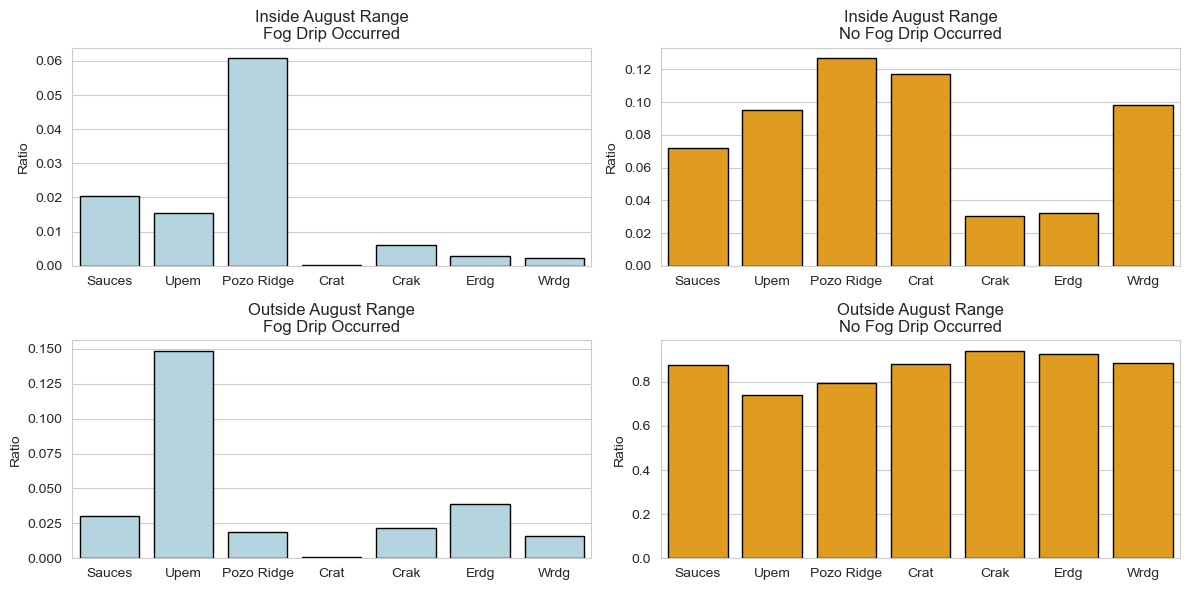

In [59]:
#### Plot Summary ####
results_bar_plot(results_df)

['air_temp', 'RH']


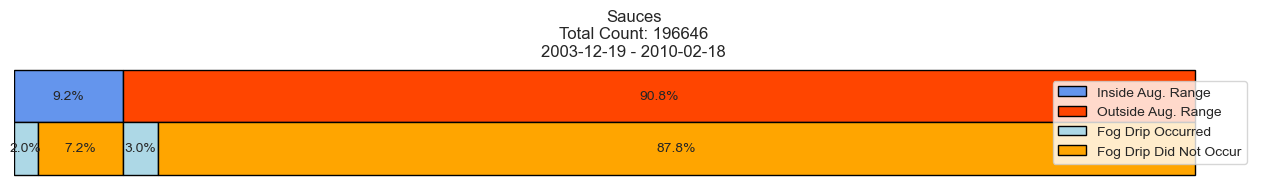

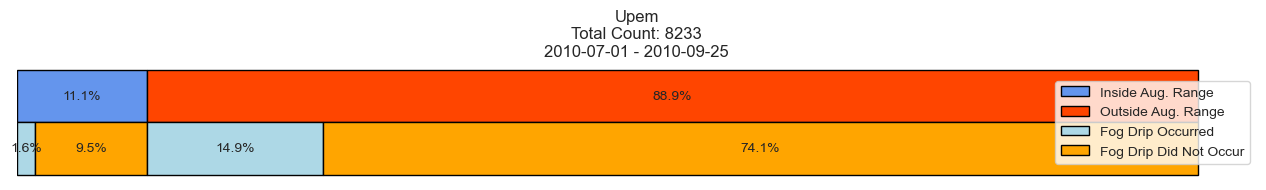

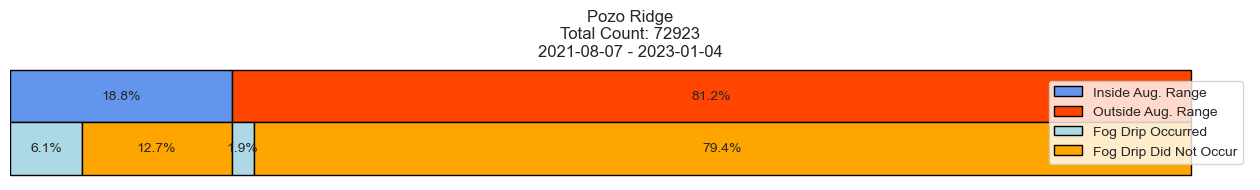

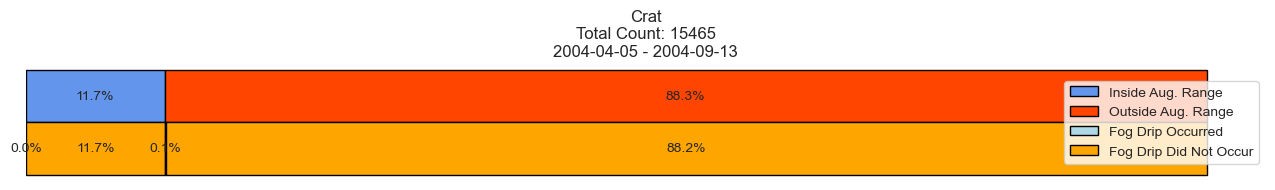

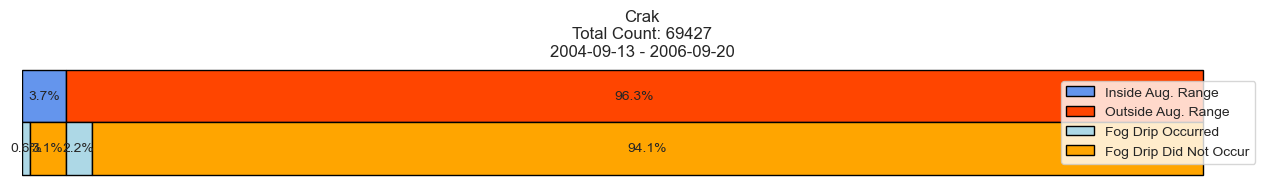

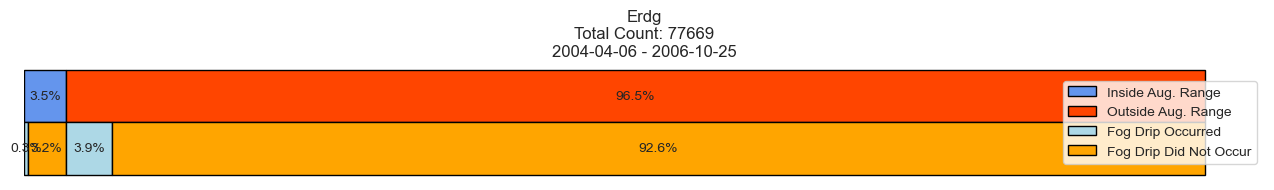

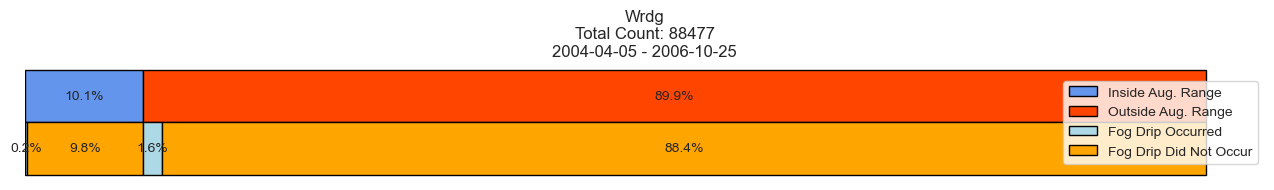

In [60]:
#### Plot Site Specific Data ####
print(feature_list)
out_dir = './figures/fog-envelope-figs'
for i in range(len(results_df)):

    out_fname = results_df.iloc[i]['site']
    out_fpath = os.path.join(out_dir, out_fname)
    plot_results(results_df.iloc[i], figsize=(16, 1.5), out_fpath=out_fpath)

## Weekly Visualizations
Where are these points falling within fog events?  

In [61]:
df = pozo_df.copy()
# Define transition points between states

df['transition'] = False
transition_list = df['transition'].copy()
state = df['condition'].iloc[0]
for i, row in df.iterrows():
    if row['condition'] != state:
        state = row['condition']
        transition_list[i] = True

df['transition'] = transition_list

In [62]:
# Label based on conditions
inside_df = fog_rule_filter(df, fog_conditions, feature_list, stat_bounds=('min', 'max'))
inside_indices = inside_df.index.tolist()

fog_labels = []
for i in df.index.tolist():
    if i in inside_indices:
        if df.loc[i]['condition'] == 'fog':
            fog_labels.append('inside_fog')
        else:
            fog_labels.append('inside_no_fog')
    else:
        if df.loc[i]['condition'] == 'fog':
            fog_labels.append('outside_fog')
        else:
            fog_labels.append('outside_no_fog')

df['fog_label'] = fog_labels

df.set_index('time', inplace=True, drop=False)
# Find events
events = find_fog_events(df)


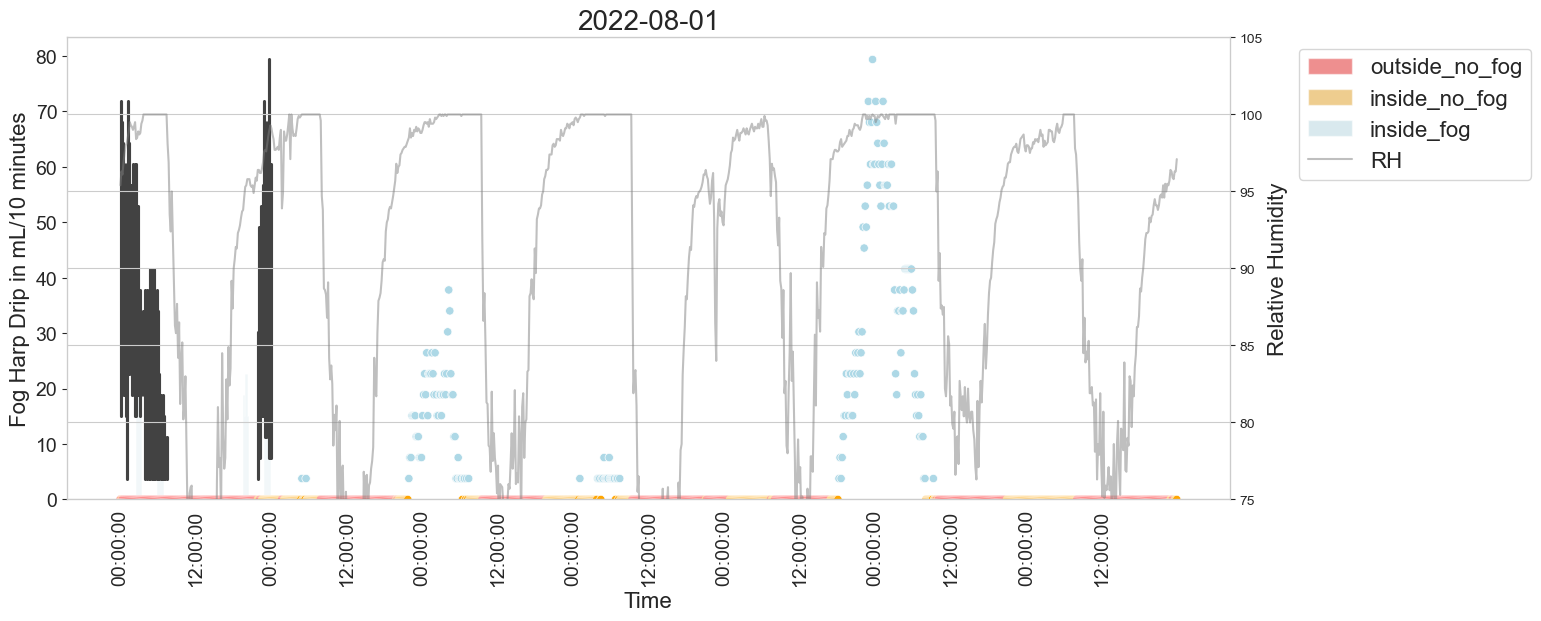

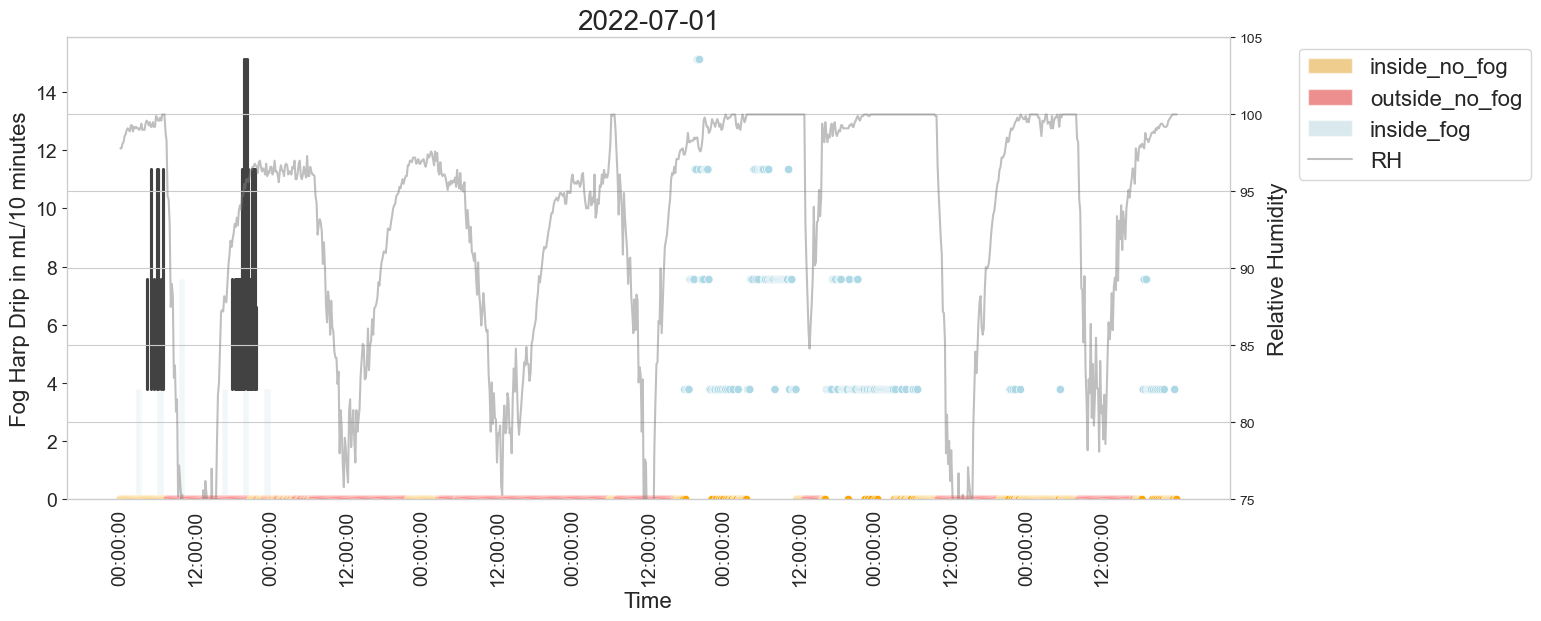

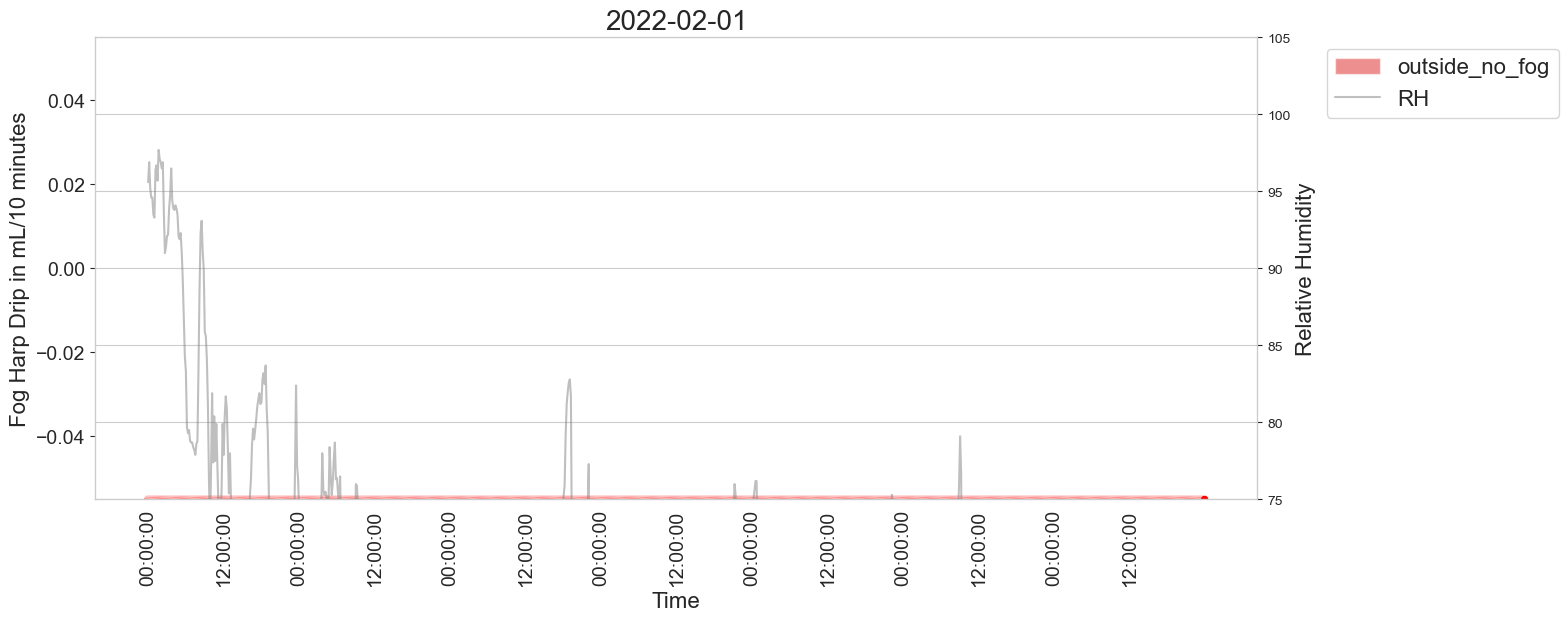

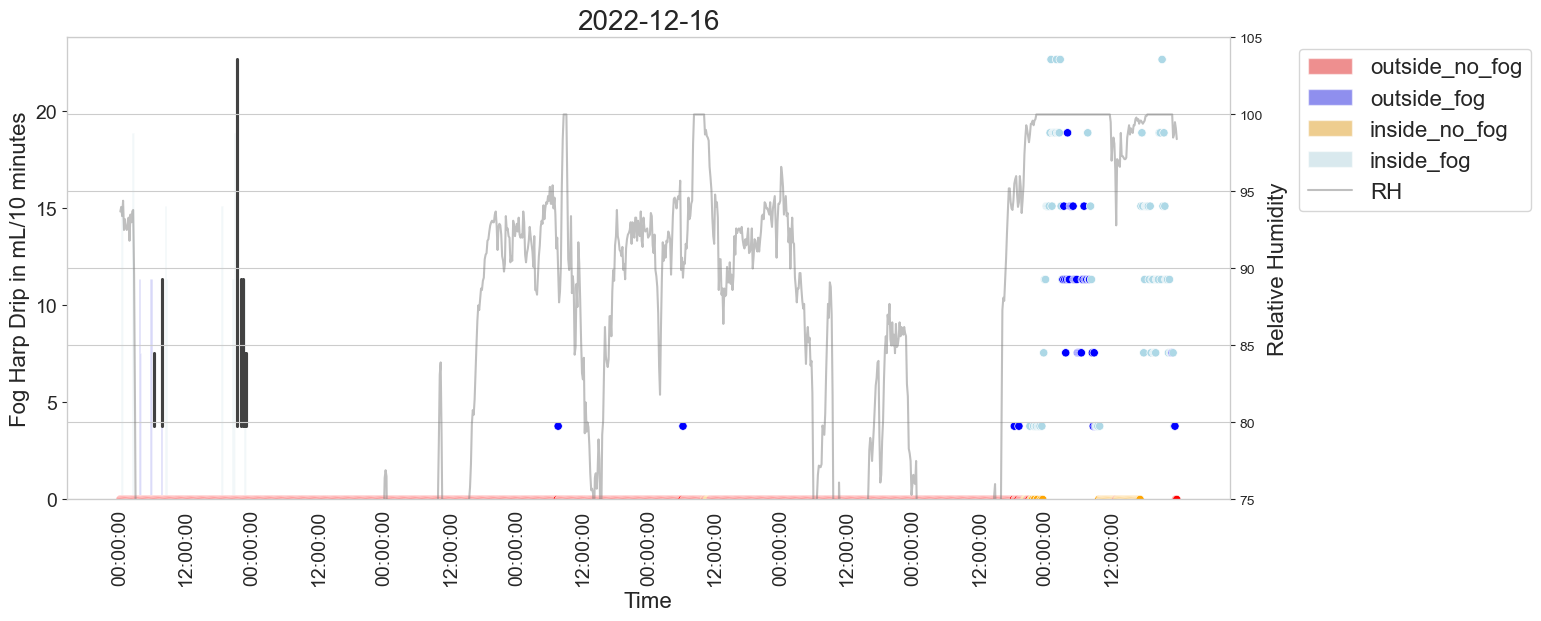

In [63]:
week = df['8-1-2022  00:00:00' : '8-7-2022  23:50:00'].reset_index(drop=True)
week_plot(week, xtick_interval=12*6)

week = df['7-1-2022  00:00:00' : '7-7-2022  23:50:00'].reset_index(drop=True)
week_plot(week, xtick_interval=12*6)

week = df['2-1-2022  00:00:00' : '2-7-2022  23:50:00'].reset_index(drop=True)
week_plot(week, xtick_interval=12*6)

week = df['12-16-2022  00:00:00' : '12-23-2022  23:50:00'].reset_index(drop=True)
week_plot(week, xtick_interval=12*6)

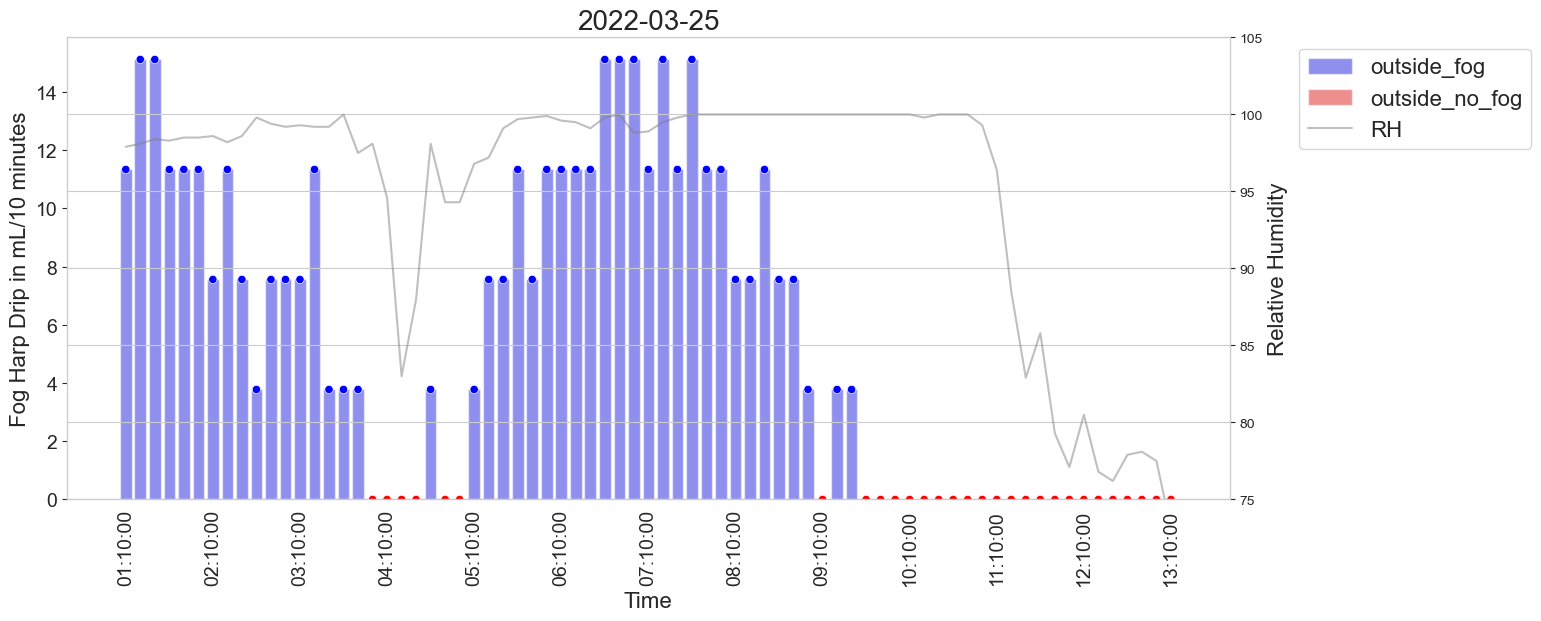

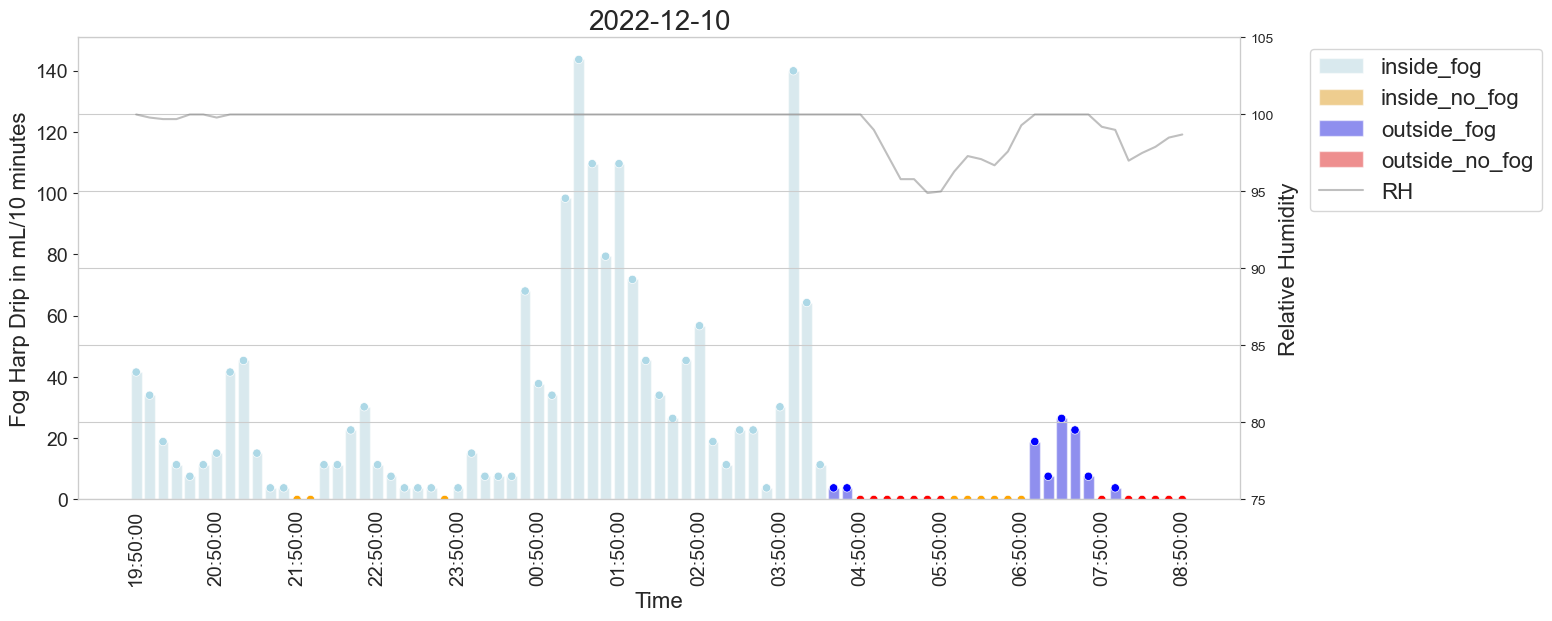

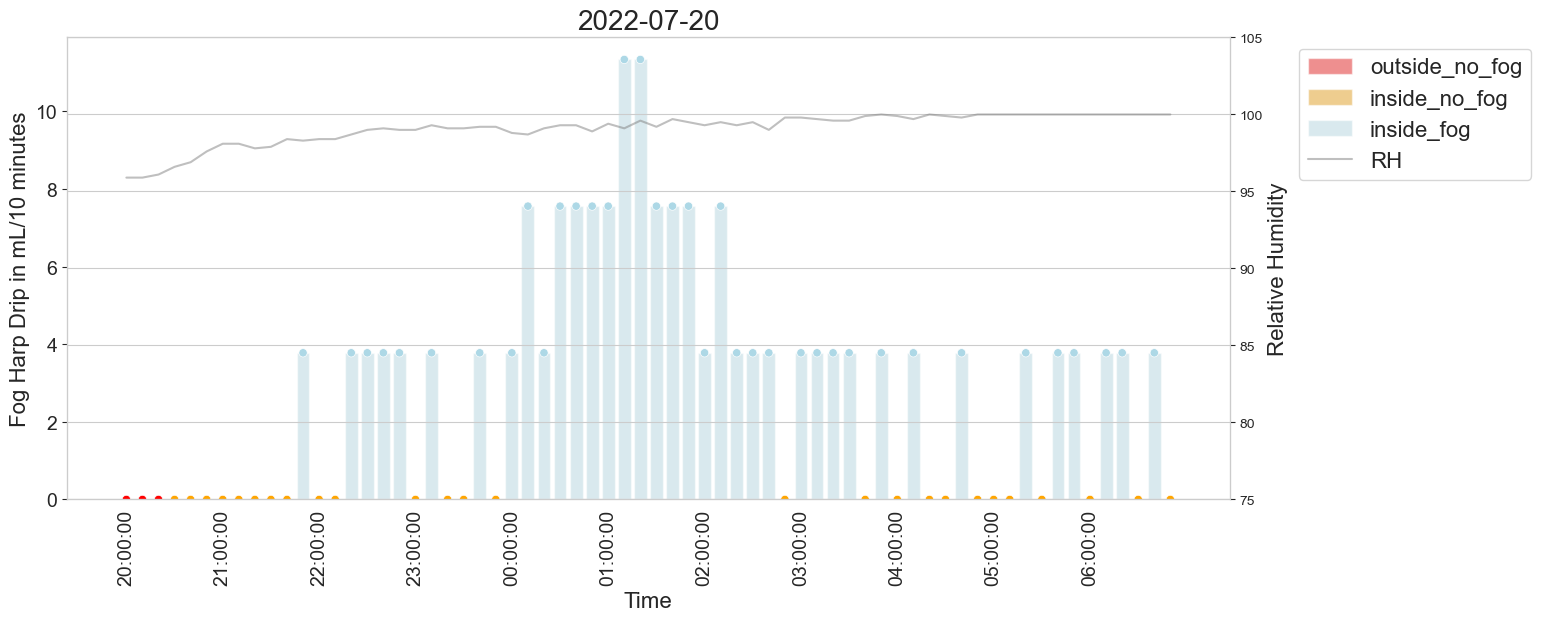

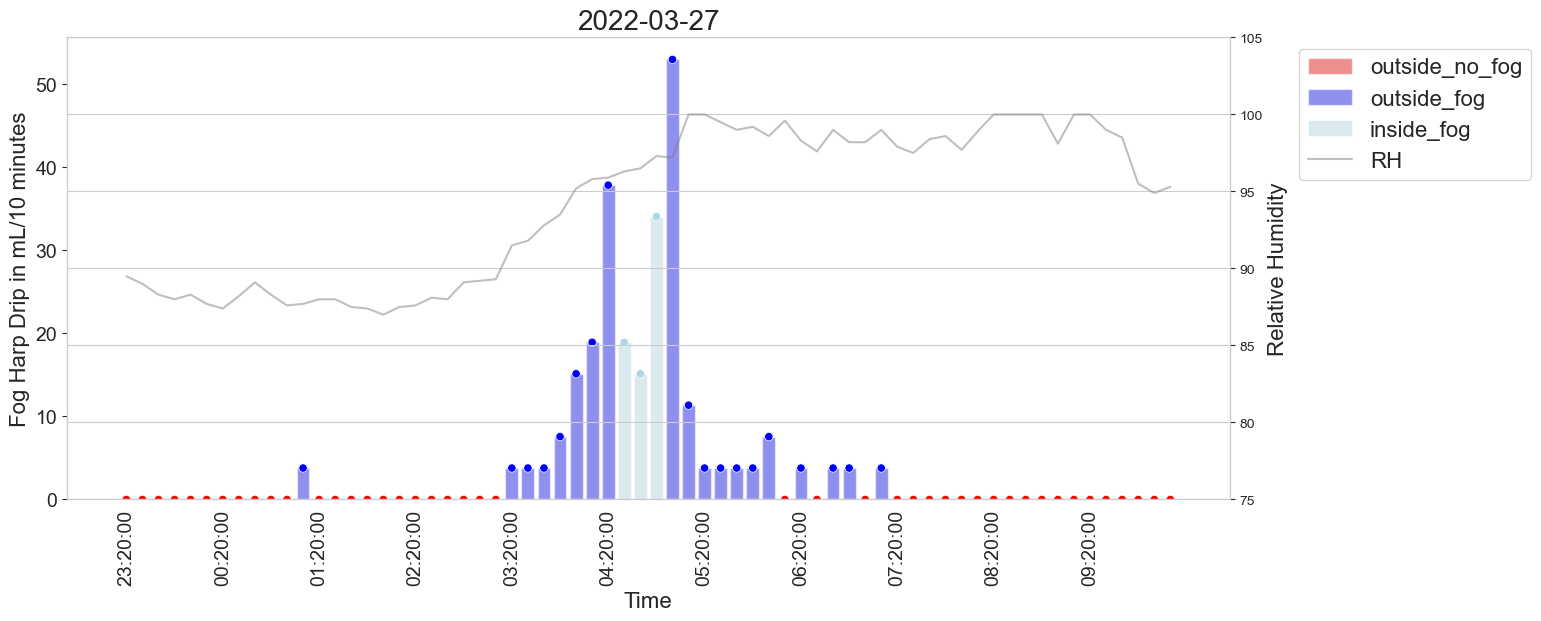

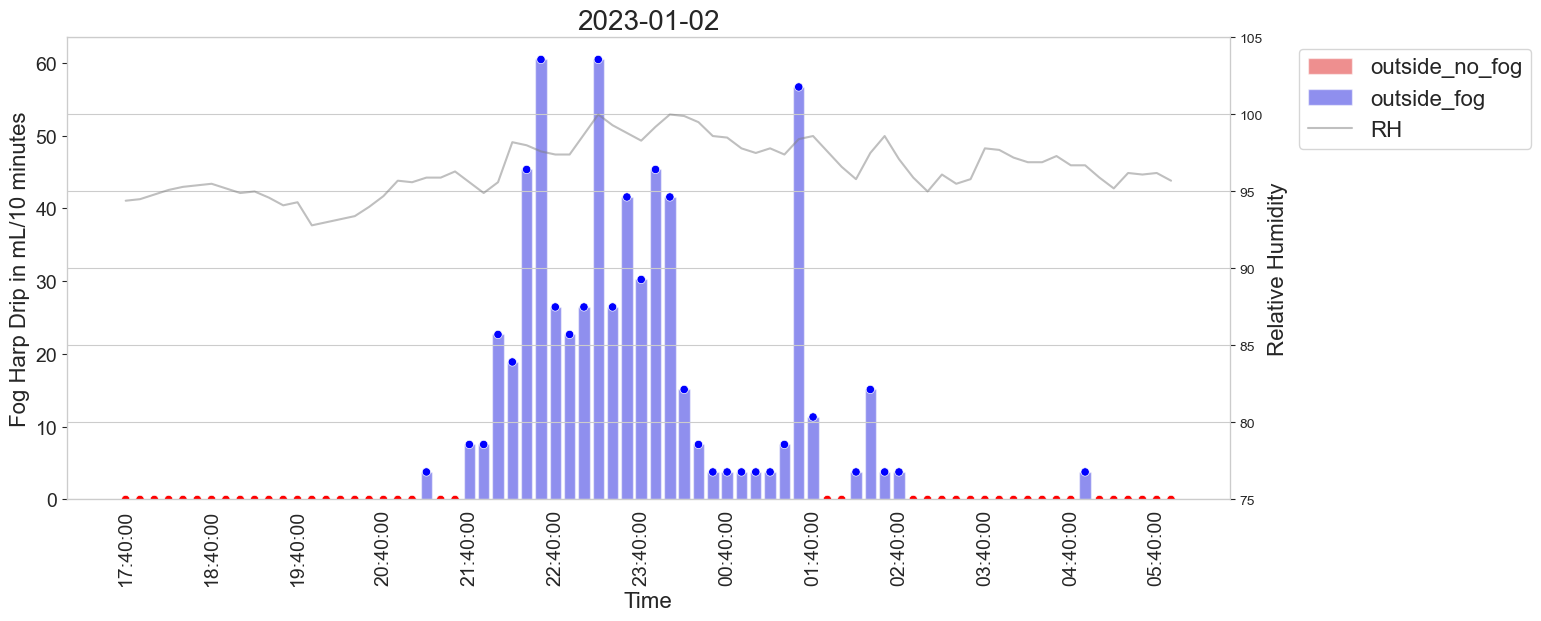

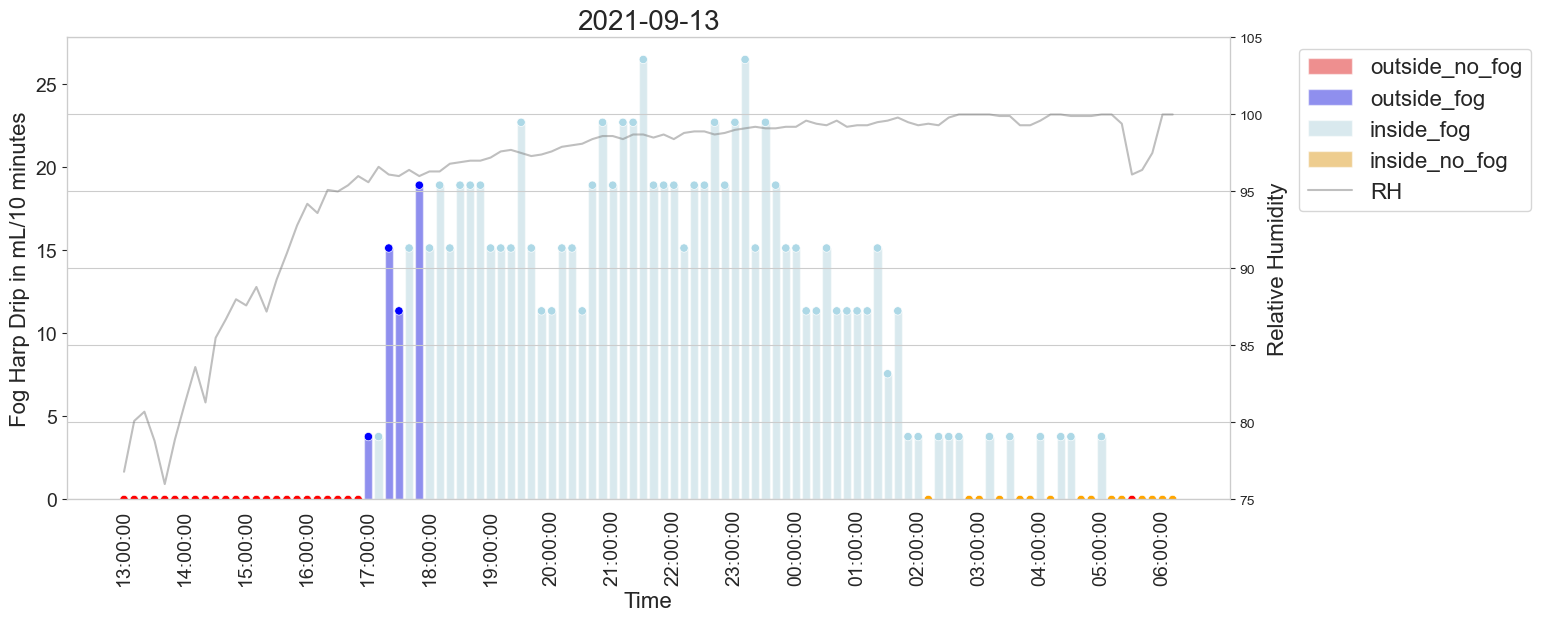

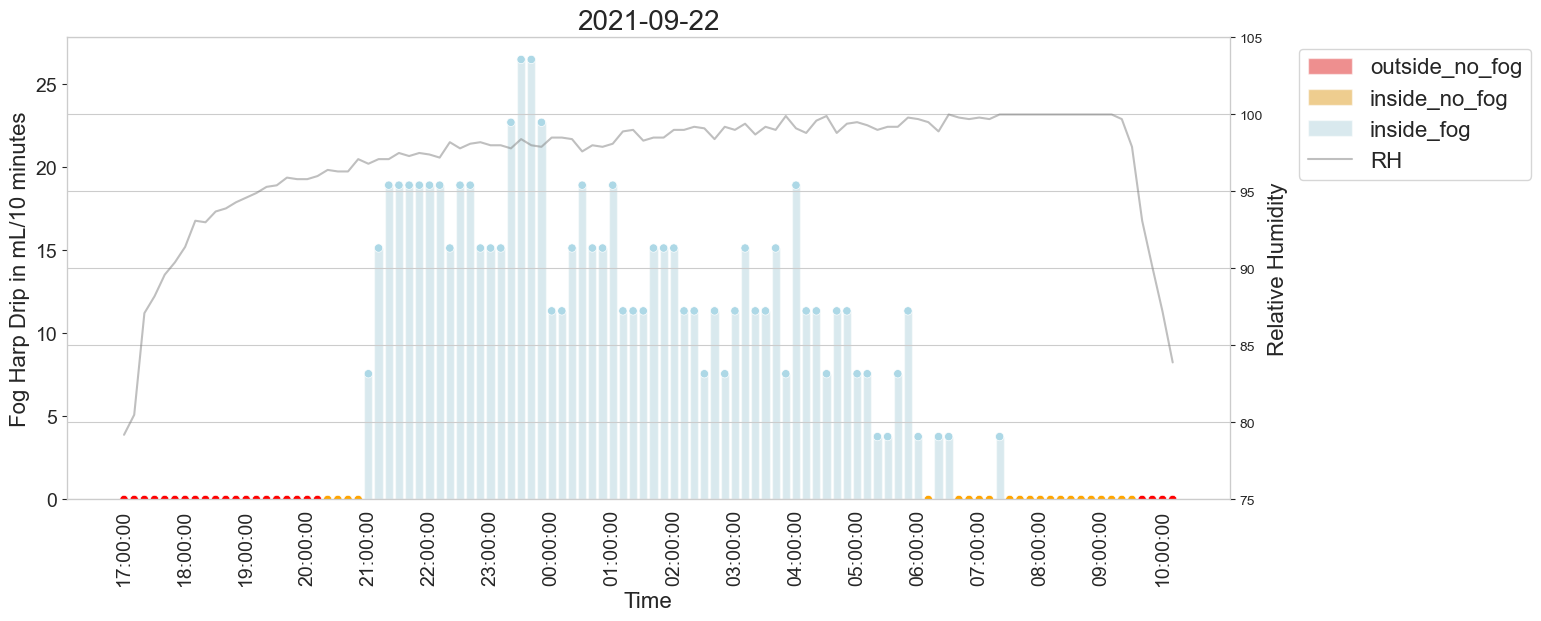

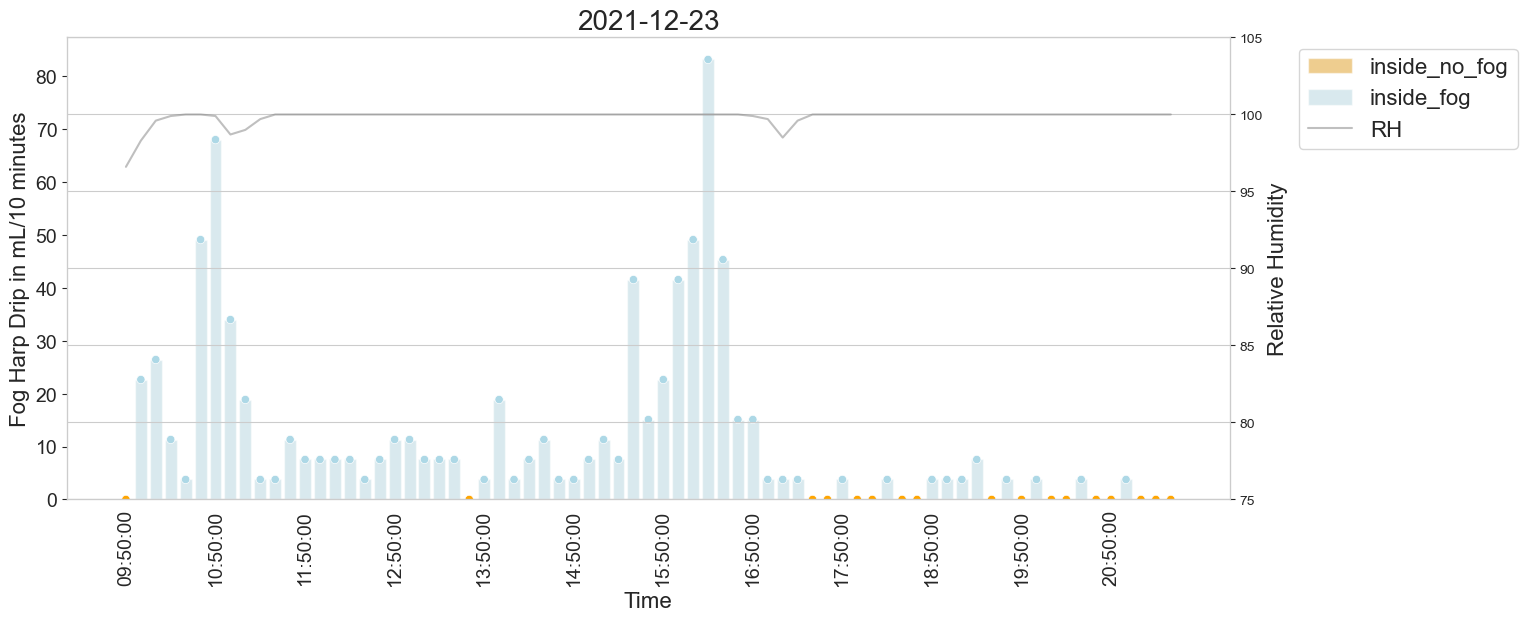

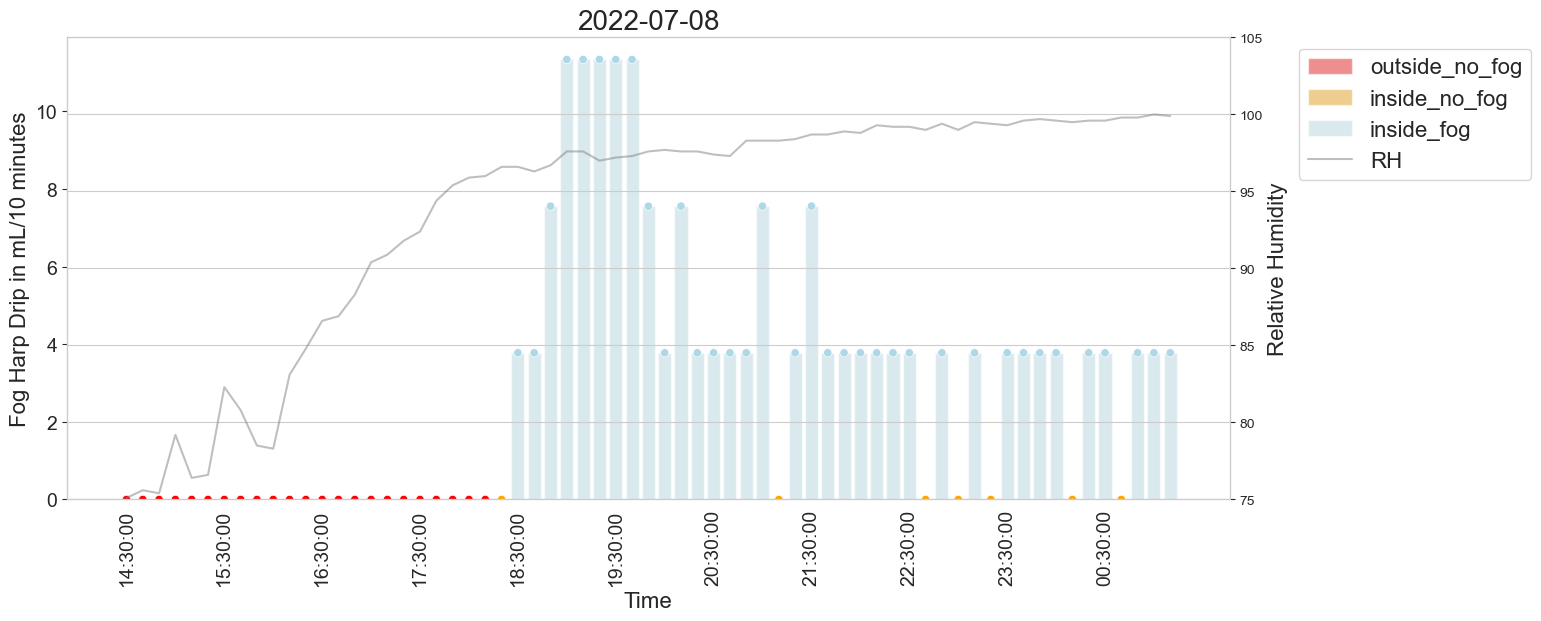

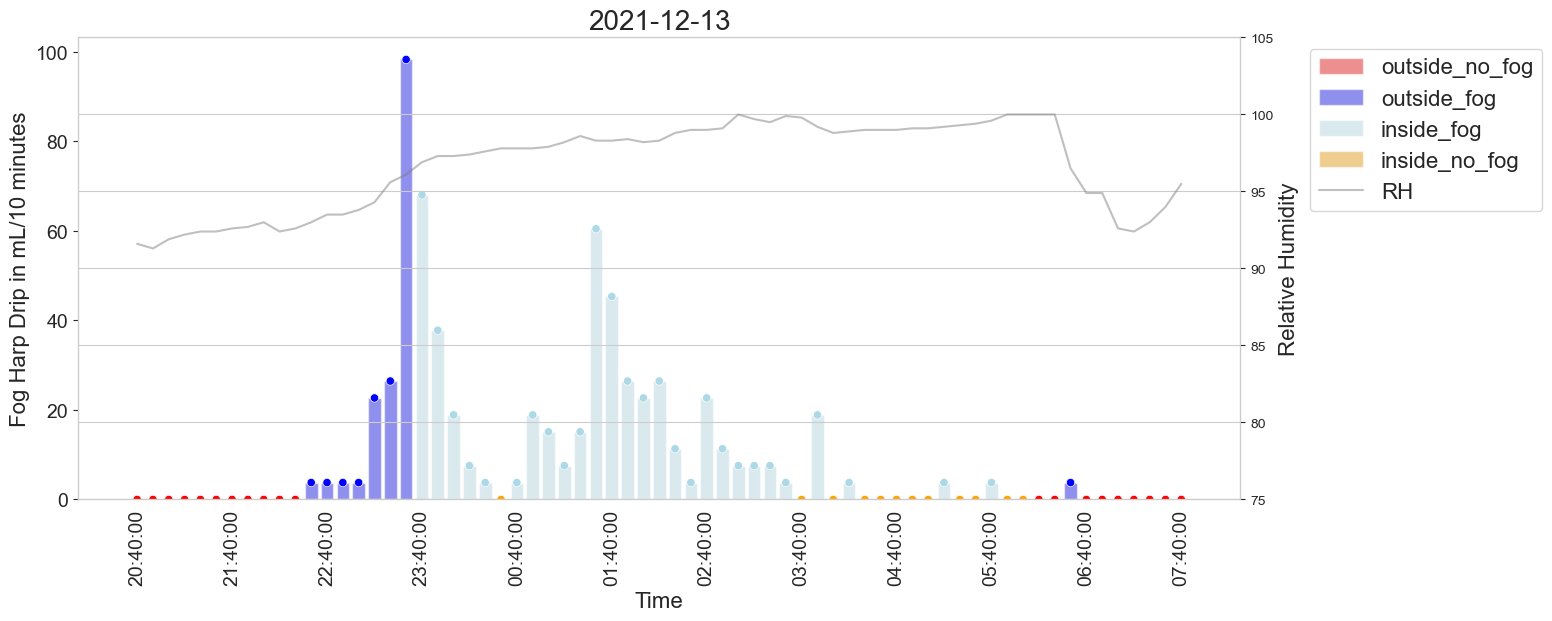

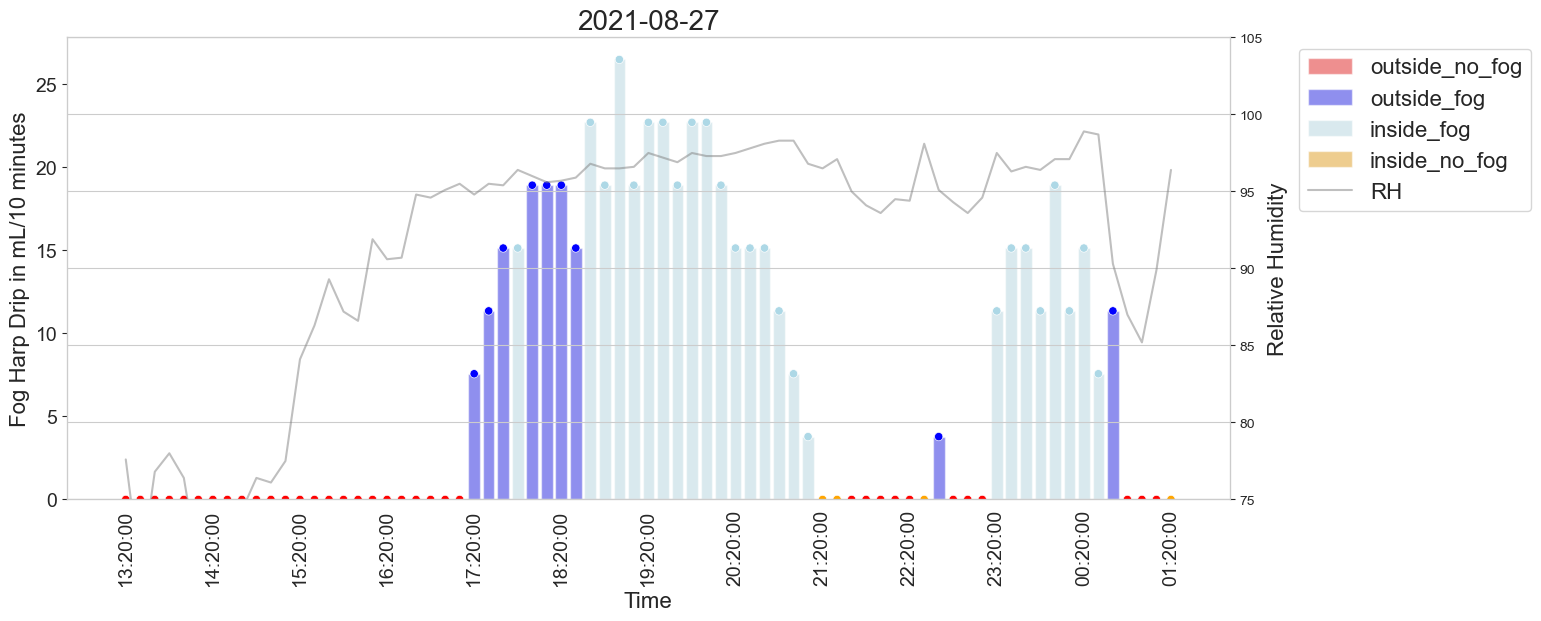

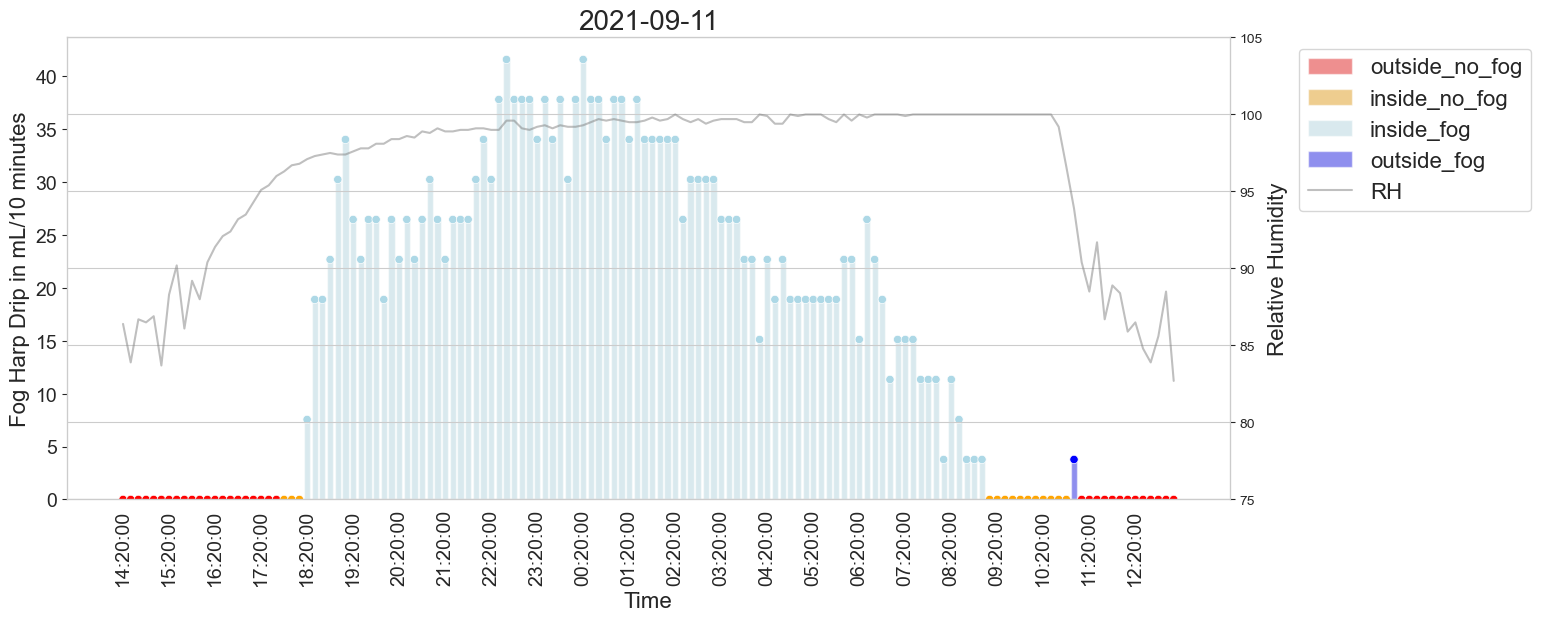

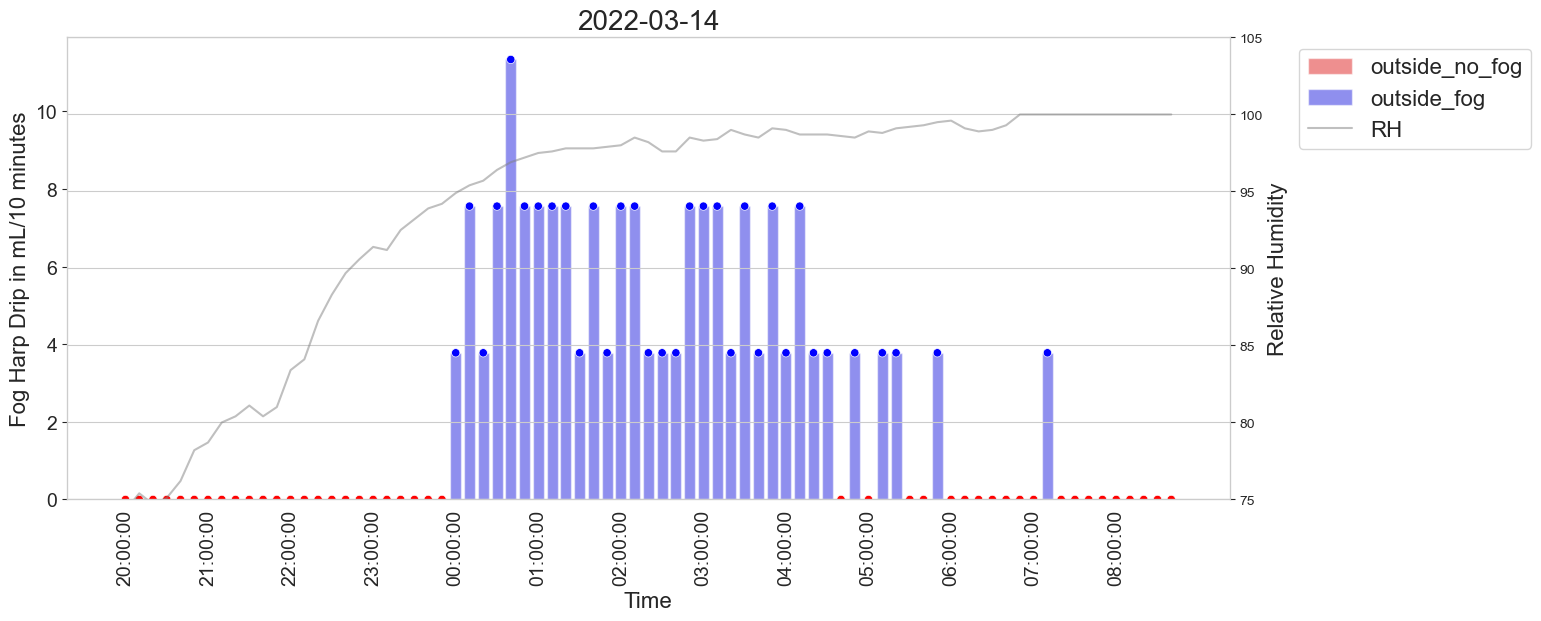

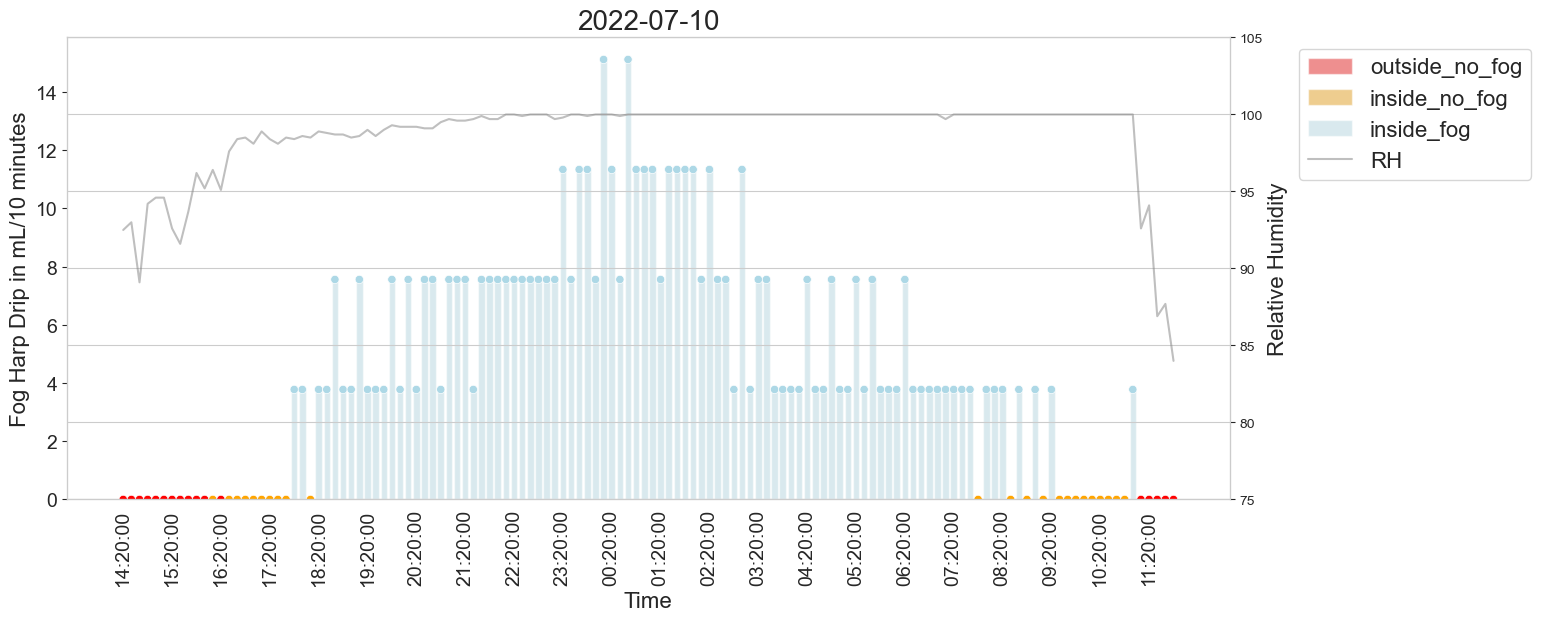

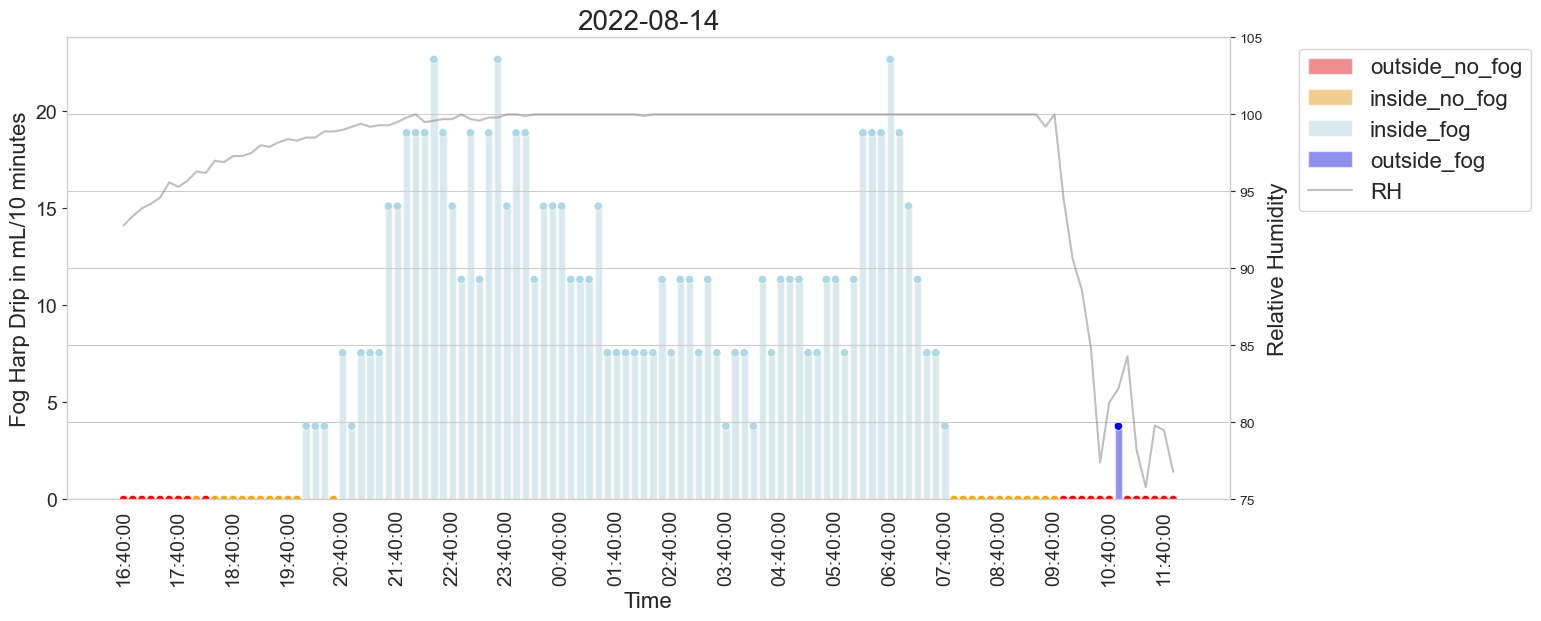

In [64]:
#### Plot fog events ####
random.seed(2468)
fog_events = find_fog_events(df)
fog_events_subset = random.sample(fog_events, 15)

for event in fog_events_subset:
    start_time = str(event[0])
    stop_time = str(event[1])

    event_df = df[start_time:stop_time]
    event_df.reset_index(inplace=True, drop=True)

    out_dir = '/Users/patmccornack/Documents/ucsb_fog_project/figures/fog_condition_figs/event_plots'
    out_fname = start_time.split(' ')[0]
    out_fpath = os.path.join(out_dir, out_fname)
    week_plot(event_df, out_fpath=None)